In [1]:
# using GuSTO
include("../src/GuSTO.jl")

┌ Info: Precompiling BulletCollision [b3564421-7037-56b3-90f4-5b7f54e2ead3]
└ @ Base loading.jl:1192


HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/75259c676c4c94b02ca26a89265c53e5a244a54a-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/75259c676c4c94b02ca26a89265c53e5a244a54a-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

Forest

In [2]:
robot = Car()
model = DubinsCar()
env = BlankEnv()

N = 100
tf_guess = 10.
x_init = 2*ones(3)
goal_set = GoalSet()
add_goal!(goal_set, Goal(PointGoal(zeros(3)), tf_guess, model))

PD = ProblemDefinition(robot, model, env, x_init, goal_set)
TOP = TrajectoryOptimizationProblem(PD, N, tf_guess, fixed_final_time=true)
TOS_SCP = TrajectoryOptimizationSolution(TOP)

TrajectoryOptimizationSolution(Trajectory([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0], 10.0, 0.10101010101010101), #undef, #undef, #undef)

In [3]:
# SCP Only
TOS_SCP = TrajectoryOptimizationSolution(TOP)
# solve_SCP!(TOS_SCP, TOP, solve_gusto_jump!, init_traj_straightline, "Gurobi", OutputFlag=0)
solve_SCP!(TOS_SCP, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", print_level=0)
# solve_SCP!(TOS_SCP, TOP, solve_gusto_jump!, init_traj_straightline, "Mosek")

@show TOS_SCP.SCPS.converged
@show TOS_SCP.SCPS.convergence_measure
@show TOS_SCP.SCPS.iterations
@show TOS_SCP.SCPS.total_time
@show TOS_SCP.SCPS.J_true[end]

UndefVarError: UndefVarError: cse_init_constraints not defined

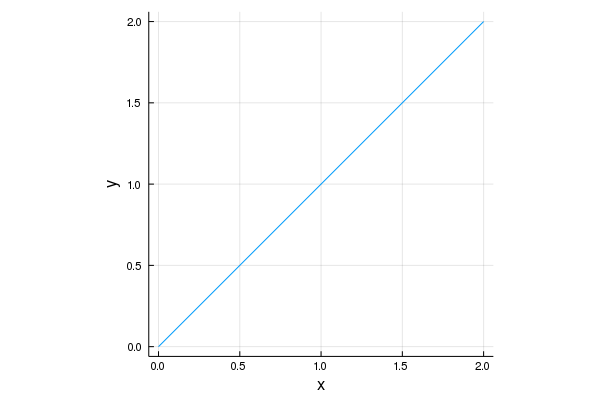

In [4]:
using Plots
gr(fmt=:png)
plot([TOS_SCP.SCPS.traj.X[1,:]], [TOS_SCP.SCPS.traj.X[2,:]],
    xlabel = "x",
    ylabel = "y",
    aspect_ratio = 1,
    legend = :none)

In [5]:
TOS_SCPS  = TrajectoryOptimizationSolution(TOP)
solve_SCPshooting!(TOS_SCPS, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", print_level=0)

@show TOS_SCPS.SS.converged
@show TOS_SCPS.SS.prob_status
@show TOS_SCPS.SCPS.iterations
@show TOS_SCPS.total_time
@show TOS_SCPS.SS.J_true[end]
@show TOS_SCPS.SCPS.dual

UndefVarError: UndefVarError: cse_init_constraints not defined

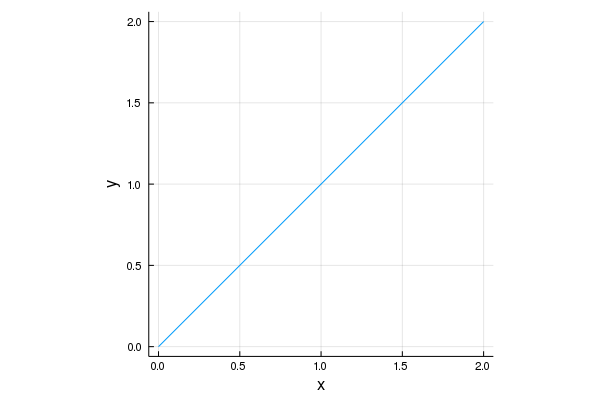

In [6]:
using Plots
gr(fmt=:png)
plot([TOS_SCPS.SS.traj.X[1,:]], [TOS_SCPS.SS.traj.X[2,:]],
    xlabel = "x",
    ylabel = "y",
    aspect_ratio = 1,
    legend = :none)

In [7]:
# TOS_SCPS.SS.J_true

In [8]:
# TOS_SCPS.SCPS.J_true

In [9]:
TOS_SCPS.SCPS.iterations

0

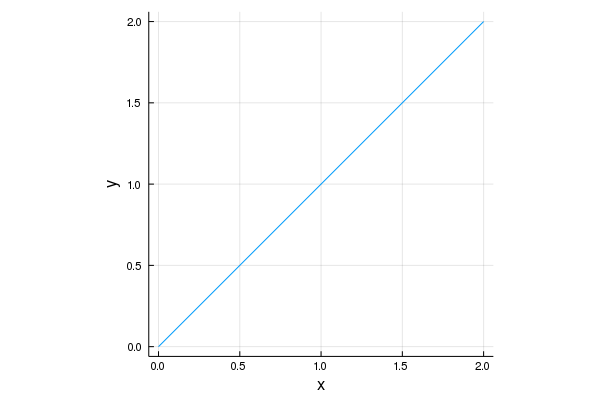

In [10]:
using Plots
gr(fmt=:png)
plot([TOS_SCPS.SCPS.traj.X[1,:]], [TOS_SCPS.SCPS.traj.X[2,:]],
    xlabel = "x",
    ylabel = "y",
    aspect_ratio = 1,
    legend = :none)

In [11]:
@show TOS_SCPS.SCPS.dual
dt = tf_guess/(N-1)
tspan = (0., tf_guess)
SP = ShootingProblem(TOP, TOS_SCPS.SCPS)
x0 = [TOP.PD.x_init; TOS_SCPS.SCPS.dual]
prob = ODEProblem(shooting_ode!, x0, tspan, SP)
sol = DifferentialEquations.solve(prob, dtmin=dt, force_dtmin=true, saveat=dt);

(TOS_SCPS.SCPS).dual = Any[]


StackOverflowError: StackOverflowError:

In [12]:
X_ODE = zeros(3,N)
for i = 1:N
    X_ODE[:,i] = sol.u[i][1:3]
end
X_ODE

UndefVarError: UndefVarError: sol not defined

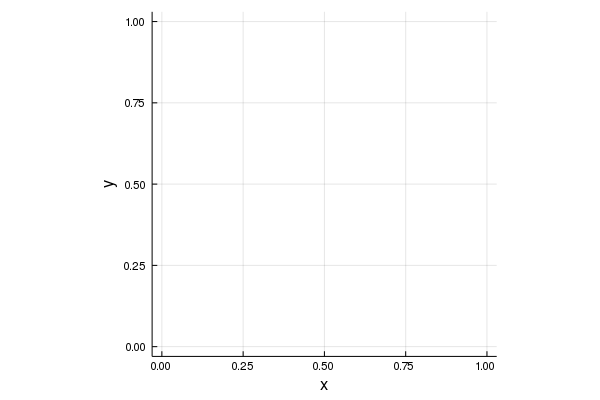

In [13]:
using Plots
gr(fmt=:png)
plot([X_ODE[1,:]], [X_ODE[2,:]],
    xlabel = "x",
    ylabel = "y",
    aspect_ratio = 1,
    legend = :none)

In [14]:
solver_model = Model(with_optimizer(Ipopt.Optimizer; print_level=0))
N = 100
dt = tf_guess/(N-1)
model = TOP.PD.model
x_max, x_min, u_max, u_min, v, k = model.x_max, model.x_min, model.u_max, model.u_min, model.v, model.k
@variable(solver_model, x_min[1] <= x[1:N] <= x_max[1])
@variable(solver_model, x_min[2] <= y[1:N] <= x_max[2]) 
@variable(solver_model, x_min[3] <= θ[1:N] <= x_max[3])
@variable(solver_model, u_min <= u[1:N-1] <= u_max)
@NLconstraint(solver_model, dyn_x[k=1:N-1], x[k+1] == x[k] + dt*v*cos(θ[k]))
@NLconstraint(solver_model, dyn_y[k=1:N-1], y[k+1] == y[k] + dt*v*sin(θ[k]))
@NLconstraint(solver_model, dyn_θ[k=1:N-1], θ[k+1] == θ[k] + dt*k*u[k])
@constraint(solver_model, con_init, [x[1];y[1];θ[1]] .== x_init)
@constraint(solver_model, con_goal, [x[N];y[N];θ[N]] .== x_goal)
@objective(solver_model, Min, sum(u[k]^2 for k = 1:N-1))

UndefVarError: UndefVarError: x_goal not defined

In [15]:
# solver_model

In [16]:
JuMP.optimize!(solver_model)
JuMP.termination_status(solver_model)
JuMP.objective_value(solver_model)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



0.0

In [17]:
x_sol = JuMP.value.(x[1,:])
using Plots
gr(fmt=:png)
plot([x_sol], [y_sol],
    xlabel = "x",
    ylabel = "y",
    aspect_ratio = 1,
    legend = :none)

UndefVarError: UndefVarError: y_sol not defined

In [18]:
p0 = -JuMP.dual.(con_init)

3-element Array{Float64,1}:
 -5.494144503759745e-10
 -7.125959878119682e-11
 -6.355480590872e-10   

In [19]:
u0 = JuMP.value.(u[1])
@show pθ0 = 2*u0/k 

pθ0 = (2u0) / k = -1.8366942399730888


-1.8366942399730888

In [20]:
p0[3]/pθ0

3.4602823118588973e-10

In [21]:
@show TOS_SCPS.SCPS.dual
dt = tf_guess/(N-1)
tspan = (0., tf_guess)
SP = ShootingProblem(TOP, TOS_SCPS.SCPS)
x0 = [TOP.PD.x_init; p0]
prob = ODEProblem(shooting_ode!, x0, tspan, SP)
sol = DifferentialEquations.solve(prob);

(TOS_SCPS.SCPS).dual = Any[]


In [22]:
X_ODE = zeros(3,N)
for i = 1:N
    X_ODE[:,i] = sol.u[i][1:3]
end
X_ODE

BoundsError: BoundsError: attempt to access 4-element Array{Array{Float64,1},1} at index [5]

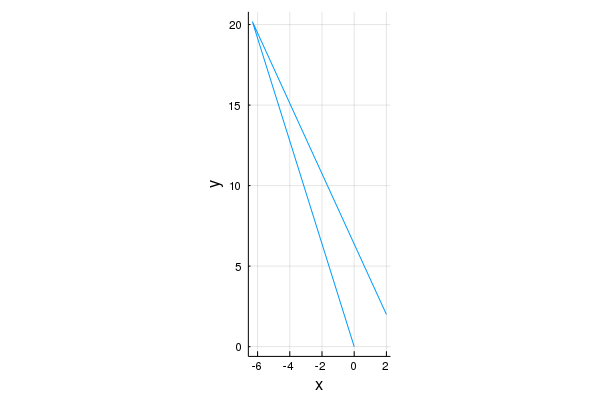

In [23]:
using Plots
gr(fmt=:png)
plot([X_ODE[1,:]], [X_ODE[2,:]],
    xlabel = "x",
    ylabel = "y",
    aspect_ratio = 1,
    legend = :none)